In [1]:
%cd "/home/jorgen/deepshape/deepshape/"
%load_ext autoreload
%autoreload 2

/home/jorgen/deepshape/deepshape


In [2]:
import torch 
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm, colors

import time

In [3]:
from layers import FourierLayer2D
from palais_layer import *
from surfaces import *
from visual import *
from networks import *
from curves import LogStepDiff

plt.rcParams["figure.figsize"] = (8.3, 5.6)
plt.rcParams["font.size"] = 16
plt.rcParams["xtick.labelsize"] = 16
plt.rcParams["ytick.labelsize"] = 16

In [6]:
savepath = "/home/jorgen/masters-thesis-shape-analysis/chapter05/figures/deep/cylinder/"

C = (
    lambda x: torch.sin(2*np.pi*x[..., 0]),
    lambda x: torch.sin(4*np.pi*x[..., 0]),
    lambda x: x[..., 1]
)

f = Surface(C)
γ = Diffeomorphism(
    (
        lambda x: 0.9*x[..., 0]**2 + 0.1 * x[..., 0],
        lambda x: (0.5 * torch.log(20*x[..., 1]+1) / torch.log(21*torch.ones(1)) 
          + 0.25 * (1 + torch.tanh(20*(x[..., 1]-0.5)) / torch.tanh(21*torch.ones(1))))
    )
)

g = f.compose(γ)
q = Qmap(g)
r = Qmap(f)

# Get color normalizer
k = 256
fcolors = get_plot_data(f.volume_factor, k=k).squeeze()
gcolors = get_plot_data(g.volume_factor, k=k).squeeze()
norm = colors.Normalize(vmin=min(fcolors.min(), gcolors.min()), vmax=max(fcolors.max(), gcolors.max()))

In [ ]:
k = 256
Z = get_plot_data(g, k=k)
gcolors = get_plot_data(g.volume_factor, k=k).squeeze()

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection='3d')
ax.plot_surface(*Z, shade=False, facecolors=cm.jet(norm(gcolors)), rstride=1, cstride=1)
ax.view_init(35, 225)
plt.savefig(savepath + "warped-surface.png", bbox_inches="tight")
plt.show()

Z = get_plot_data(f, k=k)
fcolors = get_plot_data(f.volume_factor, k=k).squeeze()

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection='3d')
ax.plot_surface(*Z, shade=False, facecolors=cm.jet(norm(fcolors)), rstride=1, cstride=1)
ax.view_init(35, 225)
plt.savefig(savepath + "regular-surface.png", bbox_inches="tight")
plt.show()

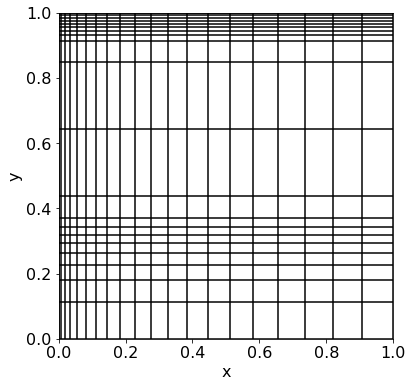

In [15]:
fig = plt.figure(figsize=(6, 6))
plot_diffeomorphism(γ, k=21, color="k")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("x")
plt.ylabel("y")
plt.savefig(savepath + "base-diffeomorphism.pdf", bbox_inches="tight")
plt.show()

In [9]:
# Create Datapoints
k = 32
K = k**2
X = torch.rand(K, 2)
X, Y = torch.meshgrid((torch.linspace(0, 1, k), torch.linspace(0, 1, k)))
X, Y = X.reshape(-1, 1), Y.reshape(-1, 1)
X = torch.cat((X, Y), dim=1)

Q = q(X)
R = r(X)

tic = time.time()

bfgs_iter = 300
iterations = 1

# Instantiate a L-layer network with N basis functions per layer.
RN = ReparametrizationNetwork2D(3, 15, layer_type=PalaisLayer2D)
optimizer = optim.LBFGS(RN.parameters(), lr=0.9, max_iter=bfgs_iter, max_eval=bfgs_iter, line_search_fn="strong_wolfe")
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1, threshold=0.,
                                                 threshold_mode='rel', cooldown=10, min_lr=1e-3, eps=1e-08, verbose=True)
loss = nn.MSELoss()

printiter= 20
errors = np.empty(bfgs_iter * iterations)
errors[:] = np.nan

tic = time.time()

for i in range(iterations):
    print("Iteration i")
    inner = [0]
    
    def closure():
        # Set gradient buffers to` zero.
        optimizer.zero_grad()
        
        with torch.no_grad():
            Z = X
            for layer in RN.layers:
                layer.project(Z, 1e-3, 1e-3)
                Z, _ = layer(Z)

        Q = q(X)
        R = RN.reparametrized(r, X)

        # Compute loss, and perform a backward pass and gradient step
        l = loss(Q, R) * 3
        l.backward()
        scheduler.step(l)
        
        j = i * bfgs_iter + inner[0]
        errors[j] = l.item()
        inner[0] += 1

        
        print('[Iter %5d] loss: %8f' % (j, l))
        return l
    
    optimizer.step(closure)
#     scheduler.step(closure())

                
    # Should insert projection step here as well (has not been necessary until now) 
toc = time.time()

print()
print(f'Finished training in {toc - tic:.5f}s')

Iteration i
[Iter     0] loss: 15.418686
[Iter     1] loss: 6.682478
[Iter     2] loss: 4.247530
[Iter     3] loss: 3.325656
[Iter     4] loss: 2.388175
[Iter     5] loss: 1.925173
[Iter     6] loss: 1.033236
[Iter     7] loss: 0.520479
[Iter     8] loss: 0.392583
[Iter     9] loss: 0.154489
[Iter    10] loss: 0.124376
[Iter    11] loss: 0.094894
[Iter    12] loss: 0.056875
[Iter    13] loss: 0.028559
[Iter    14] loss: 0.020588
[Iter    15] loss: 0.012897
[Iter    16] loss: 0.010063
[Iter    17] loss: 0.007328
[Iter    18] loss: 0.004831
[Iter    19] loss: 0.003805
[Iter    20] loss: 0.003239
[Iter    21] loss: 0.002848
[Iter    22] loss: 0.002468
[Iter    23] loss: 0.001935
[Iter    24] loss: 0.001604
[Iter    25] loss: 0.001282
[Iter    26] loss: 0.001181
[Iter    27] loss: 0.001067
[Iter    28] loss: 0.000955
[Iter    29] loss: 0.000874
[Iter    30] loss: 0.000822
[Iter    31] loss: 0.000774
[Iter    32] loss: 0.000702
[Iter    33] loss: 0.000633
[Iter    34] loss: 0.000582
[Iter  

[Iter   293] loss: 0.000050
[Iter   294] loss: 0.000050
[Iter   295] loss: 0.000050
[Iter   296] loss: 0.000050
[Iter   297] loss: 0.000049
[Iter   298] loss: 0.000049
[Iter   299] loss: 0.000049

Finished training in 67.69920s


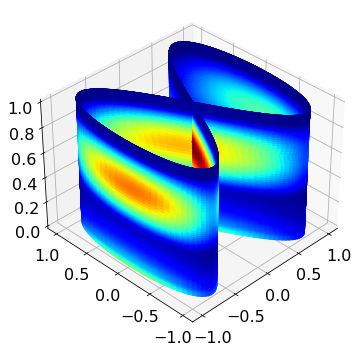

In [10]:
k = 230
fafter = f.compose(lambda x: RN(x)[0])
Z = get_plot_data(fafter, k=k)
fafcolors = get_plot_data(fafter.volume_factor, k=k).squeeze()

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection='3d')
ax.plot_surface(*Z, shade=False, facecolors=cm.jet(norm(fafcolors)), rstride=1, cstride=1)
ax.view_init(35, 225)
plt.savefig(savepath + "regular-warped-matched-surface.png", bbox_inches="tight")
plt.show()

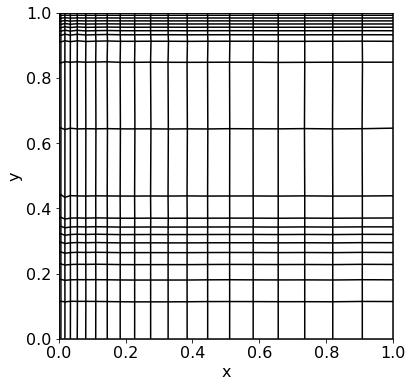

In [13]:
fig = plt.figure(figsize=(6, 6))
plot_diffeomorphism(lambda x: RN(x)[0], k=21, color="k")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("x")
plt.ylabel("y")
plt.savefig(savepath + "regular-warped-diffeomorphism.pdf", bbox_inches="tight")
plt.show()

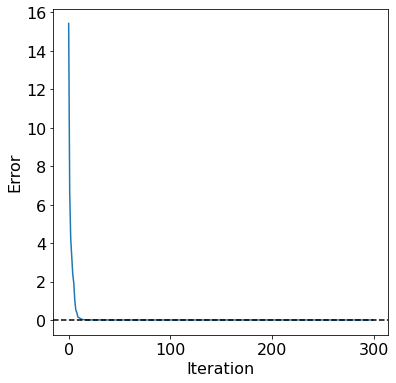

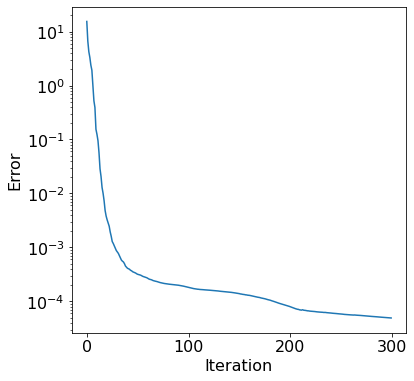

In [12]:
plt.figure(figsize=(6, 6))
plt.plot(errors)
plt.axhline(0., ls="--", c="black")

plt.ylabel("Error", fontsize=16)
plt.xlabel("Iteration", fontsize=16)
plt.savefig(savepath + "regular-warped-error-linear.pdf", bbox_inches="tight")

plt.figure(figsize=(6, 6))
plt.semilogy(errors)
plt.axhline(0., ls="--", c="black")
plt.ylabel("Error", fontsize=16)
plt.xlabel("Iteration", fontsize=16)
plt.savefig(savepath + "regular-warped-error-semilogy.pdf", bbox_inches="tight")

plt.show()

In [6]:
# Create Datapoints
k = 256
K = k**2
X = torch.rand(K, 2)
X, Y = torch.meshgrid((torch.linspace(0, 1, k), torch.linspace(0, 1, k)))
X, Y = X.reshape(-1, 1), Y.reshape(-1, 1)
X = torch.cat((X, Y), dim=1)

Z, Y = RN(X)
(γ(X) - Z).norm(np.inf)

tensor(0.0053, grad_fn=<NormBackward1>)